In [1]:
# make the notebook more readable:
import warnings
warnings.filterwarnings('ignore')

import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path:
    sys.path.append(module_path)

# Moist adiabat vs. Monsoon deltas

We want a simple way to produce a atmospheric (vertical) temperature profile under global warming, to use in our LES setup. This profile should match our observed values from the *Monsoon 2.0* simulations, but also allow us to realise other, more severe temperature perturbations than the observed 1.4 degree surface warming. In a first approximation we tried a simple constructed moist adiabat based on higher surface temperatures. This approach does not reproduce all features of the atmospheric temperature profile in a warmer world correctly. This notebook explores the fits and mismatches of our profile with the moist adiabat.


## The *real* data

In a previous notebook we prepared mean vertical profiles from *Monsoon 2.0* data. These profiles are means over the month april (temporal), the EUREC4A domain (spatial) and multiple ensemble members (statistical). 

In [2]:
import xarray as xr
warm = xr.open_dataset('../00_preliminary/data/luk102X_ssp585_trades.nc')
cold = xr.open_dataset('../00_preliminary/data/luk100X_control_trades.nc')

The Monsoon data shows warming that seems to following a moist adiabat. The Tropopause is lifted, the cold-point temperature is slightly higher and the surface temperature is increased. Warming is less severe near the surface, with only slightly elevated surface temperatures.

In [3]:
import numpy as np

def orderly_print_values(warm, cold, title, precision=(0,0)):
    print(title)
    print(f'   SSP585 : {warm:.{precision[0]}f}')
    print(f'   Control: {cold:.{precision[0]}f}')
    print(f'   Delta  : {warm-cold:.{precision[1]}f}')
    print()

orderly_print_values(warm['pfull'].values[-1], cold['pfull'].values[-1],       'surface pressure [Pa]:')
orderly_print_values(warm['ta'].values[-1], cold['ta'].values[-1],             'surface temperature [K]:', precision=(1,2))
orderly_print_values(np.nanmin(warm['ta'].values), np.nanmin(cold['ta'].values), 'cold-point temperature [K]: ', precision=(1,2))
orderly_print_values(warm['zg'].values[np.nanargmin(warm['ta'].values)], cold['zg'].values[np.nanargmin(cold['ta'].values)], 'cold-point height [m]: ')

surface pressure [Pa]:
   SSP585 : 101191
   Control: 101046
   Delta  : 145

surface temperature [K]:
   SSP585 : 299.9
   Control: 298.5
   Delta  : 1.37

cold-point temperature [K]: 
   SSP585 : 194.6
   Control: 192.9
   Delta  : 1.65

cold-point height [m]: 
   SSP585 : 18176
   Control: 17408
   Delta  : 768



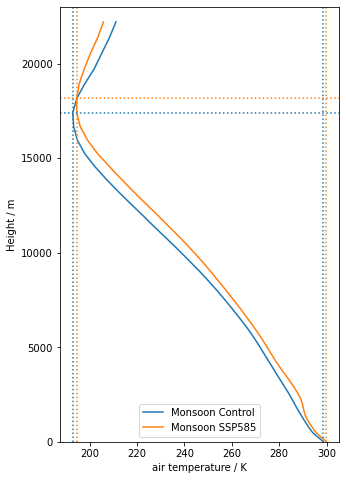

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def geometry_comparison_plot(ax,data,var, highlight=None, 
                             labels=['control','perturbed'],
                             colors=['tab:blue','tab:orange']):
    if highlight:
        ax.axhspan(*highlight, alpha=0.1)
    ax.plot(data[0][var].values, data[0]['zg'].values, label=labels[0], color=colors[0])
    ax.plot(data[1][var].values, data[1]['zg'].values, label=labels[1], color=colors[1])

    ax.axhline(data[0]['zg'].values[np.nanargmin(data[0][var].values)], color=colors[0], ls=':')
    ax.axhline(data[1]['zg'].values[np.nanargmin(data[1][var].values)], color=colors[1], ls=':')

    ax.axvline(np.nanmin(data[0][var].values), color=colors[0], ls=':')
    ax.axvline(np.nanmin(data[1][var].values), color=colors[1], ls=':')
    ax.axvline(data[0][var].values[-1], color=colors[0], ls=':')
    ax.axvline(data[1][var].values[-1], color=colors[1], ls=':')

    ax.set_xlabel(f"{data[0][var].attrs['name']} / {data[0][var].units}")
    ax.set_ylabel('Height / m')
    ax.set_ylim([0,23000])
    ax.legend()

figsize=(5,8)
fig, ax = plt.subplots(figsize=figsize)
geometry_comparison_plot(ax,[cold,warm],'ta', labels=['Monsoon Control', 'Monsoon SSP585'])
plt.show()

## Warming along the moist adiabat

In a first approximation we can calculate the moist adiabatic temperature profile, based on a pressure profile and a surface temperature. The python package *konrad* does provide such a function. Here as an additional input the cold point temperature is requested: [`get_moist_adiabat(p, p_s=None, T_s=300.0, T_min=155.0)`](https://konrad.readthedocs.io/_autosummary/konrad.lapserate.get_moist_adiabat.html).



In [ ]:
import numpy as np
import metpy.calc as mpcalc
from metpy.units import units
import matplotlib.pyplot as plt
import plot_utils as pu

def hydrostratic_profile(h, p_surf):
    p = np.zeros(len(h))
    p[0] = p_surf
    # mpcalc.add_height_to_pressure(pressure, height)
    # https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.add_height_to_pressure.html
    # Calculate the pressure at a certain height above another pressure level.
    # This assumes a standard atmosphere [NOAA1976].
    for i in range(1,len(p)):
        pressure = p[i-1] * units('Pa')
        height   = (h[i] - h[i-1]) * units('m')
        calc = mpcalc.add_height_to_pressure(pressure, height).to(units('Pa'))
        p[i] = calc.magnitude
    return p

from konrad.lapserate import get_moist_adiabat
# get_moist_adiabat(p, p_s=None, T_s=300.0, T_min=155.0)
# https://konrad.readthedocs.io/_modules/konrad/lapserate.html#get_moist_adiabat
def plot_adiabat(ax, p_surf, T_s, T_min, **kwargs):
    global ymax
    h = np.linspace(0, ymax, num=100)
    p = hydrostratic_profile(h, p_surf)
    t = get_moist_adiabat(p,  T_s=T_s, T_min=T_min)
    # p = hydrostratic_profile(h, p_surf)
    plot = ax.plot(t,h, **kwargs)
    # ax.axhline(t.where)
    # print(np.where(t==np.argmin(t),[t]))
    # where(condition[, x, y])
    return plot

deltaT = 4
ymax = 18000
p_surf = 100000
T_s = 300
T_min = 190.0
figsize = (5,8)

fig, ax = plt.subplots(figsize=figsize)
plot_adiabat(ax, p_surf, T_s, T_min, label='$T_{surf} = 300$')
plot_adiabat(ax, p_surf, T_s+deltaT, T_min, label='$T_{surf} = 300$ + ' + str(deltaT))
ax.set_xlabel('Temperature / K')
ax.set_ylabel('Height / m')
ax.set_ylim([0,ymax])
ax.legend()
plt.show()

ModuleNotFoundError: No module named 'plot_utils'

In the above figure we raised the surface temperature by 4 degree. The Monsoon ensemble shows a less distict warming of only around 1.4 degrees.

If use the smaller surface temperature perturbation, the lifting of the cold point tropopause is also much smaller. 

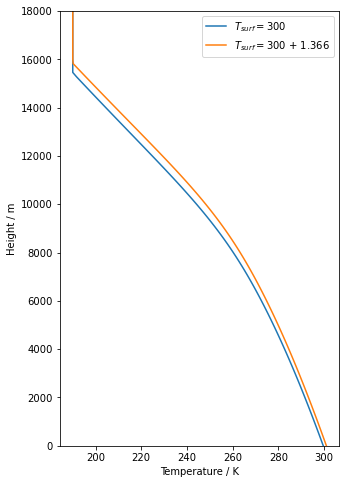

In [6]:
deltaT = 1.366

fig, ax = plt.subplots(figsize=figsize)
plot_adiabat(ax, p_surf, T_s, T_min, label='$T_{surf} = 300$')
plot_adiabat(ax, p_surf, T_s+deltaT, T_min, label='$T_{surf} = 300$ + ' + str(deltaT))
ax.set_xlabel('Temperature / K')
ax.set_ylabel('Height / m')
ax.set_ylim([0,ymax])
ax.legend()
plt.show()

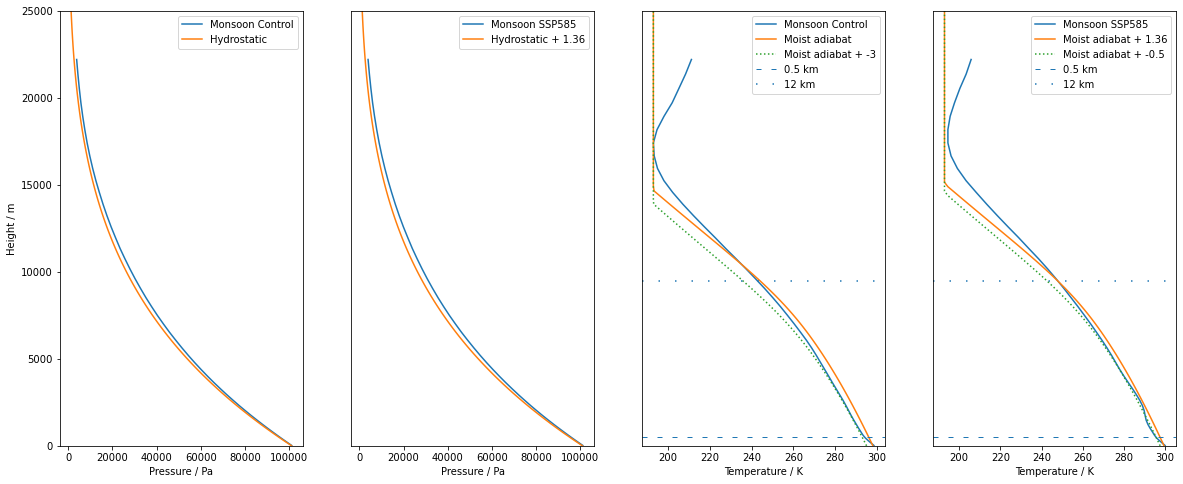

In [7]:
import numpy as np
import metpy.calc as mpcalc
from metpy.units import units
import matplotlib.pyplot as plt
import plot_utils as pu

ymax = 25000
deltaT = 1.36

def hydrostratic_profile(h, p_surf):
    p = np.zeros(len(h))
    p[0] = p_surf
    # mpcalc.add_height_to_pressure(pressure, height)
    # https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.add_height_to_pressure.html
    # Calculate the pressure at a certain height above another pressure level.
    # This assumes a standard atmosphere [NOAA1976].
    for i in range(1,len(p)):
        pressure = p[i-1] * units('Pa')
        height   = (h[i] - h[i-1]) * units('m')
        calc = mpcalc.add_height_to_pressure(pressure, height).to(units('Pa'))
        p[i] = calc.magnitude
    return p
        
def plot_metpy_hydrostatic(ax, p_surf, **kwargs):
    global ymax
    h = np.linspace(0, ymax, num=100)
    p = hydrostratic_profile(h, p_surf)
    plot = ax.plot(p,h, **kwargs)
    return plot

def plot_adiabat(ax, p_surf, T_s, T_min, **kwargs):
    global ymax
    h = np.linspace(0, ymax, num=100)
    p = hydrostratic_profile(h, p_surf)
    t = get_moist_adiabat(p,  T_s=T_s, T_min=T_min)
    # p = hydrostratic_profile(h, p_surf)
    plot = ax.plot(t,h, **kwargs)
    return plot

fig, axs = plt.subplots(1,4,figsize=(20,8))

ax = axs[0]
ax.plot(cold['pfull'].values, cold['zg'].values, label='Monsoon Control')
p_surf = cold['pfull'].values[-1]
plot_metpy_hydrostatic(ax, p_surf, label='Hydrostatic')
ax.set_xlabel('Pressure / Pa')
ax.set_ylabel('Height / m')
ax.set_ylim([0,ymax])
ax.legend()

ax = axs[1]
ax.plot(warm['pfull'].values, warm['zg'].values, label='Monsoon SSP585')
plot_metpy_hydrostatic(ax, p_surf+deltaT, label=f'Hydrostatic + {deltaT}')
ax.set_xlabel('Pressure / Pa')
ax.set_ylim([0,ymax])
pu.remove_ticks(ax, borders=['left', 'right'])
ax.legend()

ax = axs[2]
ax.plot(cold['ta'].values, cold['zg'].values, label='Monsoon Control')
p_surf = cold['pfull'].values[-1]
T_s = cold['ta'].values[-1]
T_min = np.nanmin(cold['ta'].values)
plot_adiabat(ax, p_surf, T_s, T_min, label='Moist adiabat')
arbitrary_adjustment = -3
plot_adiabat(ax, p_surf, T_s+arbitrary_adjustment, T_min, label=f'Moist adiabat + {arbitrary_adjustment}', ls=':')
ax.axhline(500, ls=(0, (5, 10)), lw=1, label='0.5 km')
ax.axhline(9500, ls=(0, (1, 10)), lw=1.5, label='12 km')
ax.set_xlabel('Temperature / K')
ax.set_ylim([0,ymax])
pu.remove_ticks(ax, borders=['left', 'right'])
ax.legend()

ax = axs[3]
ax.plot(warm['ta'].values, warm['zg'].values, label='Monsoon SSP585')
plot_adiabat(ax, p_surf, T_s+deltaT, T_min, label=f'Moist adiabat + {deltaT}')
arbitrary_adjustment = -0.5
plot_adiabat(ax, p_surf, T_s+arbitrary_adjustment, T_min, label=f'Moist adiabat + {arbitrary_adjustment}', ls=':')
ax.axhline(500, ls=(0, (5, 10)), lw=1, label='0.5 km')
ax.axhline(9500, ls=(0, (1, 10)), lw=1.5, label='12 km')
ax.set_xlabel('Temperature / K')
ax.set_ylim([0,ymax])
pu.remove_ticks(ax, borders=['left', 'right'])
ax.legend()

plt.show()

In the lower part of the troposphere (roughly below 12 km) a moist adiabat is a good fit for the atmospheric temperature profile. A moist adiabat that assumes a slightly lower surface temperature fits better because in the boundary layer temperature follows the dry lapse rate. This causes is a relatively sharp decrease in temperature in the lowermost 500 m of the profile. 

In the uppermost part of the atmosphere the fit is rather bad, getting worse the higher up we move. This is mostly because the moist adiabatic approach does not include the radiative effects, that shape the temperature profile in the upper part of the atmosphere.

## Boundary layer

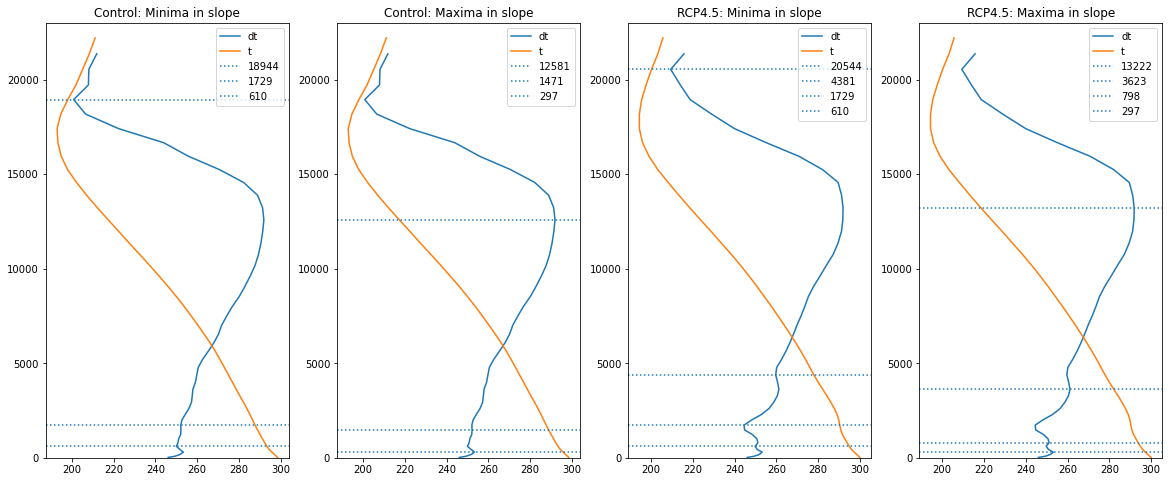

In [8]:
import numpy as np
from scipy.signal import argrelextrema

def subfig_minmax(ax, t, h, method=np.greater, title=''):
    def scale(x): # empirical...
        return x * 10 + 240
    dt = np.asarray([t[i+1] - t[i] for i in range(len(t[1::]))])
    extrema = np.asarray(argrelextrema(dt, method))
    ax.set_title(title)
    ax.plot(scale(dt), h[1::], label='dt')
    ax.plot(t,h, label='t')
    for m in np.ravel(extrema):
        line = h[1::][m]
        ax.axhline(line, ls=':',label=str(int(line)))
    ax.legend()
    ax.set_ylim([0,23000])
    return ax

fig, axs = plt.subplots(1,4,figsize=(20,8))
subfig_minmax(axs[0], cold.ta.values, cold.zg.values, method=np.less, title='Control: Minima in slope')
subfig_minmax(axs[1], cold.ta.values, cold.zg.values, method=np.greater, title='Control: Maxima in slope')
subfig_minmax(axs[2], warm.ta.values, warm.zg.values, method=np.less, title='RCP4.5: Minima in slope')
subfig_minmax(axs[3], warm.ta.values, warm.zg.values, method=np.greater, title='RCP4.5: Maxima in slope')

plt.show()

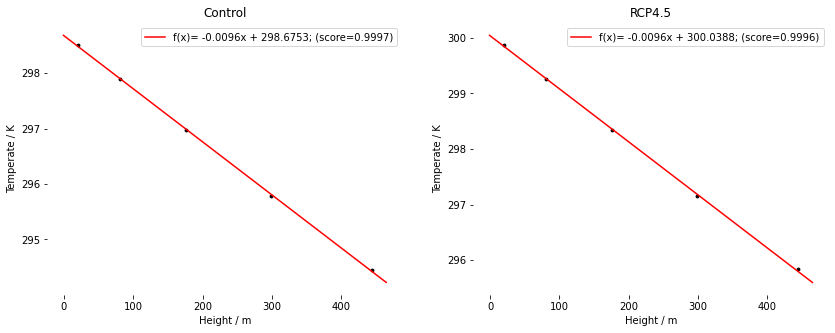

In [9]:
import numpy as np
from sklearn.linear_model import LinearRegression
import plot_utils as pu

def linear_regression_plot(ax, x,y, xinterval=None, xlabel=None, ylabel=None, print_precisions=(4,4,4)):
    if xinterval:
        y = y[x < xinterval[1]]
        x = x[x < xinterval[1]]
        y = y[x > xinterval[0]]
        x = x[x > xinterval[0]]
    x = x.reshape((-1, 1))

    model = LinearRegression().fit(x, y)
    score = model.score(x, y)
    slope = model.coef_[0]
    intercept = model.intercept_

    overlap = np.abs(np.nanmax(x)-np.nanmin(x))*0.05
    mx = np.linspace(np.nanmin(x)-overlap, np.nanmax(x)+overlap, num=1000)
    my = mx * slope + intercept

    ax.scatter(x,y, color='black',s=8)
    ax.plot(mx,my, color='r', label=f'f(x)= {slope:.4f}x + {intercept:.4f}; (score={score:.4f})')
    ax.legend()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    pu.remove_spines(ax)


fig, axs = plt.subplots(1,2,figsize=(14,5))
linear_regression_plot(axs[0], 
    x = cold['zg'].values, y = cold['ta'].values,
    xinterval  = (0,500),
    xlabel = 'Height / m',
    ylabel = 'Temperate / K'
    )
linear_regression_plot(axs[1], 
    x = warm['zg'].values, y = warm['ta'].values,
    xinterval  = (0,500),
    xlabel = 'Height / m',
    ylabel = 'Temperate / K'
    )
axs[0].set_title('Control')
axs[1].set_title('RCP4.5')
plt.show()

For both the warming and the control scenario, the lapse rate in the boundary layer (ca. <500m) is around 9 °C/km. This is lower than the theoretical value of 9.75 °C/km, because air in not dry. In the constructed moist adiabatic profiles, the lapse rate is lowest in the lowermost part. For adiabatic profiles that match the *Monsoon* surface temperatures, the lapse rates are around 4 °C/km in the boundary layer, hence the mismatch.

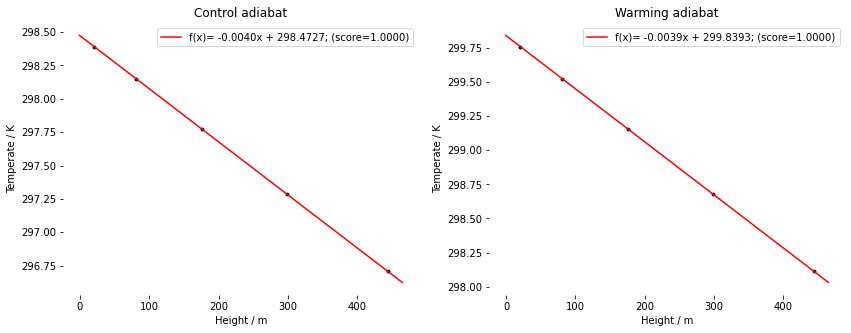

In [10]:
import boundary_tools as bdt

def drop_nan(x):
    # https://stackoverflow.com/a/47486199
    return x[~np.isnan(x)]

def get_adiabatic_profile(data):
    p_surf = data['pfull'].values[-1]
    T_s   = data['ta'].values[-1]
    T_min = np.nanmin(data['ta'].values)
    h = np.flip(data['zg'].values)
    p = bdt.hydrostatic_profile(h, p_surf)
    p = drop_nan(p)
    h = h[0:len(p)]
    t = get_moist_adiabat(p,  T_s=T_s, T_min=T_min)
    return h,t

fig, axs = plt.subplots(1,2,figsize=(14,5))

h,t = get_adiabatic_profile(cold)
linear_regression_plot(axs[0], 
    x = h, y = t,
    xinterval  = (0,500),
    xlabel = 'Height / m',
    ylabel = 'Temperate / K'
    )

h,t = get_adiabatic_profile(warm)
linear_regression_plot(axs[1], 
    x = h, y = t,
    xinterval  = (0,500),
    xlabel = 'Height / m',
    ylabel = 'Temperate / K'
    )

axs[0].set_title('Control adiabat')
axs[1].set_title('Warming adiabat')
plt.show()

A dry lapse rate could be used to compute the lowermost part of the profile. Apparently `konrad` implemented this for a boundary layer at a fixed pressure level ([documentation](https://konrad.readthedocs.io/_autosummary/konrad.lapserate.BoundaryLayer.html#konrad.lapserate.BoundaryLayer)).


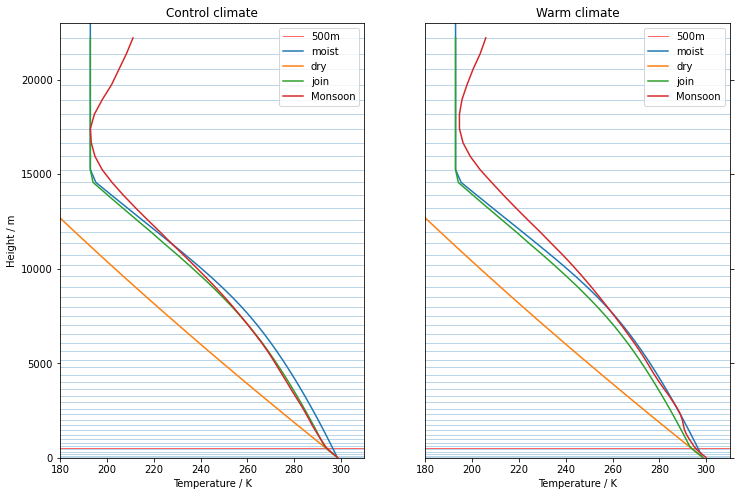

In [11]:
# warm = xr.open_dataset('luk102X_ssp585_trades.nc')
# cold = xr.open_dataset('luk100X_control_trades.nc')

def get_dry_lapse_profile(data):
    p_surf = data['pfull'].values[-1]
    T_s   = data['ta'].values[-1]
    T_min = np.nanmin(data['ta'].values)
    h = np.flip(data['zg'].values)
    p = hydrostratic_profile(h, p_surf)
    p = drop_nan(p)
    h = h[0:len(p)]
    t = mpcalc.dry_lapse(p * units('Pa'),  temperature=T_s * units('K'))#, T_min=T_min)
    return h,t

def joined_profile(data):
    maxlen = len(drop_nan(cold['pfull'].values))
    h,dry = get_dry_lapse_profile(cold)
    h = h[0:maxlen]
    dry = dry[0:maxlen]
    t = np.flip(data['ta'].values)[0:maxlen]
    p = np.flip(data['pfull'].values)[0:maxlen]
    upper_t = t[h>500]
    upper_p = p[h>500]
    T_s = upper_t[0]
    T_min = np.nanmin(upper_t)
    moist = get_moist_adiabat(upper_p,  T_s=T_s, T_min=T_min)
    tt = np.zeros(maxlen)
    tt[h<=500] = dry[h<=500]
    tt[h>500]  = moist
    return h,tt



def adiabat_fit_plot(ax, data,title):
    h,m = get_adiabatic_profile(cold)
    for lev in h:
        ax.axhline(lev,lw=1,alpha=0.3)
    ax.axhline(500,lw=1,alpha=0.6, color='r',label='500m')
    # ax.scatter(m,h,label='moist')
    ax.plot(m,h,label='moist')
    h,d = get_dry_lapse_profile(cold)
    ax.plot(d,h,label='dry')
    h,t = joined_profile(cold)
    ax.plot(t,h,label='join')
    ax.plot(data['ta'].values,data['zg'].values,label='Monsoon')
    ax.set_xlim(180,310)
    ax.set_ylim(0,23000)
    ax.set_title(title)
    ax.set_xlabel('Temperature / K')
    ax.legend()

figsize = (12,8)
fig, axs = plt.subplots(1,2,figsize=figsize)
adiabat_fit_plot(axs[0], cold, 'Control climate')
adiabat_fit_plot(axs[1], warm, 'Warm climate')
axs[0].set_ylabel('Height / m')
pu.remove_ticks(axs[1],['left'])
plt.show()

This greatly improves fit for the control simulation, but not for the warming. Fixing the boundary layer at 500m is arbitrary and might be problematic. `konrad` fixes the boundary layer at 95000 Pa, an equally arbitrary value that was chosen empirically (Lukas Kluft, personal communication, 17.11.2022).

## Upper atmosphere, Tropopause

Without additional greenhouse gases, there is no change in radiation to be expected. If Greenhouse gases are added to the atmosphere it becomes more opaque to infrared radiation. Since the emission temperature does not change (assuming an equilibrium state), but outgoing longwave radiation is emitted from higher up, the atmospheric temperature profile warms (Vallis et al., 2015). The lifting of the tropopause is similar in magnitude to the lifting of the emission height (Thuburn and Craig, 2000). If we construct our profile from the surface up, in a way we are trying a reverse approach. We are starting from the symptom (higher surface temperature), trying to reconstruct the cause (higher tropopause).

**Reference:** 
* Thuburn, J., & Craig, G. C. (2000). Stratospheric influence on tropopause height: The radiative constraint. *Journal of the atmospheric sciences*, 57(1), 17-28.
* Vallis, G. K., Zurita‐Gotor, P., Cairns, C., & Kidston, J. (2015). Response of the large‐scale structure of the atmosphere to global warming. *Quarterly Journal of the Royal Meteorological Society*, 141(690), 1479-1501.

### Using an RCE to improve upper atmosphere representation

The `konrad` package could be used to calculate radiative equilibrium for a raised surface temperature or for higher greenhouse gas concentrations.

In [12]:
import matplotlib.pyplot as plt
from typhon import plots
import konrad

def get_konrad_atmosphere(T_s, co2_mult=1.0):
    plev, phlev = konrad.utils.get_pressure_grids(1000e2, 1, 128)
    atmosphere = konrad.atmosphere.Atmosphere(phlev)
    atmosphere['CO2'] = atmosphere['CO2'] * co2_mult
    initial = konrad.atmosphere.Atmosphere(phlev).to_dataset()
    # Initialize the setup for the radiative-convective equilibrium simulation.
    rce = konrad.RCE(
        atmosphere,
        surface=konrad.surface.FixedTemperature(temperature=T_s),  # Run with a fixed surface temperature.
        timestep='12h',  # Set timestep in model time.
        max_duration='100d',  # Set maximum runtime.
    )
    rce.run()
    return atmosphere.to_dataset()

konrad_control = get_konrad_atmosphere(cold['ta'].values[-1])
konrad_ssp585  = get_konrad_atmosphere(warm['ta'].values[-1])

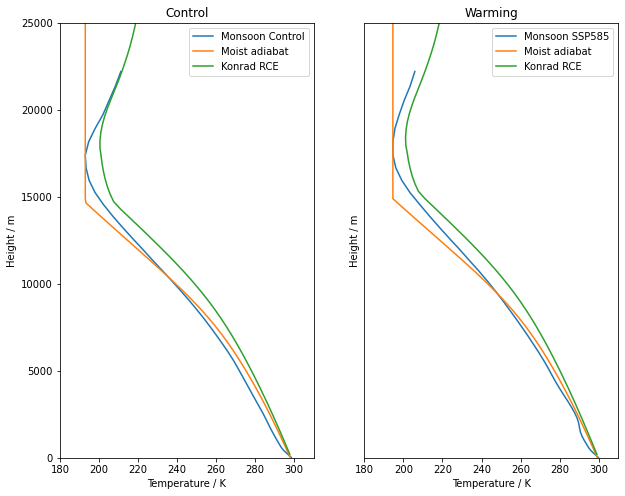

In [13]:
fig, axs = plt.subplots(1,2,figsize=(10,8))

ax = axs[0]
ax.set_title('Control')
p_surf = cold['pfull'].values[-1]
T_s = cold['ta'].values[-1]
T_min = np.nanmin(cold['ta'].values)
ax.plot(cold['ta'].values, cold['zg'].values, label='Monsoon Control')
plot_adiabat(ax, p_surf, T_s, T_min, label='Moist adiabat')
ax.plot(np.ravel(konrad_control.T.values), np.ravel(konrad_control.z.values), label='Konrad RCE')

ax = axs[1]
ax.set_title('Warming')
p_surf = warm['pfull'].values[-1]
T_s = warm['ta'].values[-1]
T_min = np.nanmin(warm['ta'].values)
ax.plot(warm['ta'].values, warm['zg'].values, label='Monsoon SSP585')
plot_adiabat(ax, p_surf, T_s, T_min, label='Moist adiabat')
ax.plot(np.ravel(konrad_ssp585.T.values), np.ravel(konrad_ssp585.z.values), label='Konrad RCE')
pu.remove_ticks(ax, borders=['left', 'right'])

xlim = 180,310
for ax in axs:
    ax.set_xlabel('Temperature / K')
    ax.set_ylabel('Height / m')
    ax.set_xlim(xlim)
    ax.set_ylim([0,ymax])
    ax.legend()

plt.show()

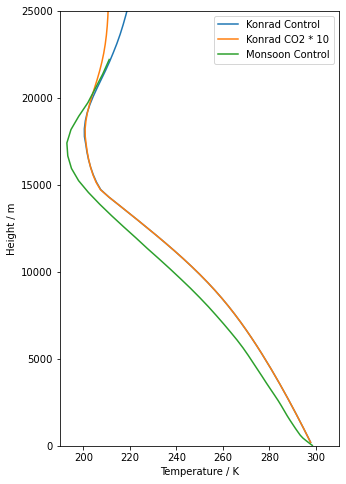

In [14]:
co2_mult = 10
konrad_c02  = get_konrad_atmosphere(cold['ta'].values[-1], co2_mult=co2_mult)

fig, ax = plt.subplots(figsize=(5,8))
ax.plot(np.ravel(konrad_control.T.values), np.ravel(konrad_control.z.values), label='Konrad Control')
ax.plot(np.ravel(konrad_c02.T.values), np.ravel(konrad_c02.z.values), label='Konrad CO2 * '+str(co2_mult))
ax.plot(cold['ta'].values, cold['zg'].values, label='Monsoon Control')

xlim = 190,310
ax.set_xlabel('Temperature / K')
ax.set_ylabel('Height / m')
ax.set_xlim(xlim)
ax.set_ylim([0,ymax])
ax.legend()

plt.show()

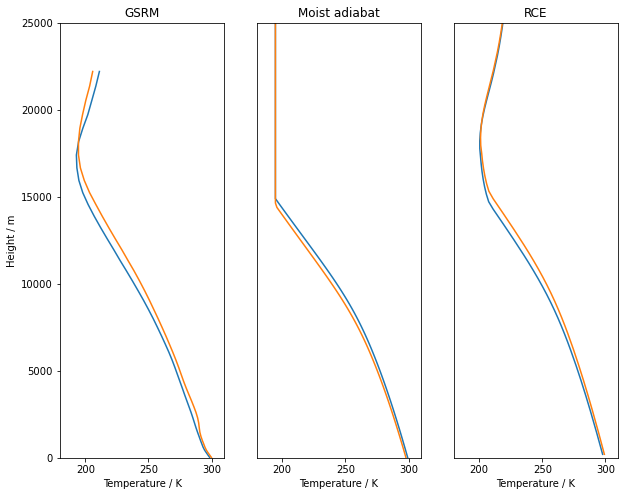

In [15]:

fig, axs = plt.subplots(1,3,figsize=(10,8))

ax = axs[0]
ax.plot(cold['ta'].values, cold['zg'].values, label='Monsoon Control')
ax.plot(warm['ta'].values, warm['zg'].values, label='Monsoon SSP585')
ax.set_xlabel('Temperature / K')
ax.set_ylabel('Height / m')
ax.set_title('GSRM')

ax = axs[1]
p_surf = warm['pfull'].values[-1]
T_s = warm['ta'].values[-1]
T_min = np.nanmin(warm['ta'].values)
plot_adiabat(ax, p_surf, T_s, T_min, label='Moist adiabat')
T_s = cold['ta'].values[-1]
plot_adiabat(ax, p_surf, T_s, T_min, label='Moist adiabat')
ax.set_xlabel('Temperature / K')
pu.remove_ticks(ax, borders=['left', 'right'])
ax.set_title('Moist adiabat')

ax = axs[2]
ax.plot(np.ravel(konrad_control.T.values), np.ravel(konrad_control.z.values), label='RCE')
ax.plot(np.ravel(konrad_ssp585.T.values), np.ravel(konrad_ssp585.z.values), label='RCE')
ax.set_title('RCE')
ax.set_xlabel('Temperature / K')
pu.remove_ticks(ax, borders=['left', 'right'])

xlim = 180,310
for ax in axs:
    ax.set_xlim(xlim)
    ax.set_ylim([0,ymax])

plt.show()

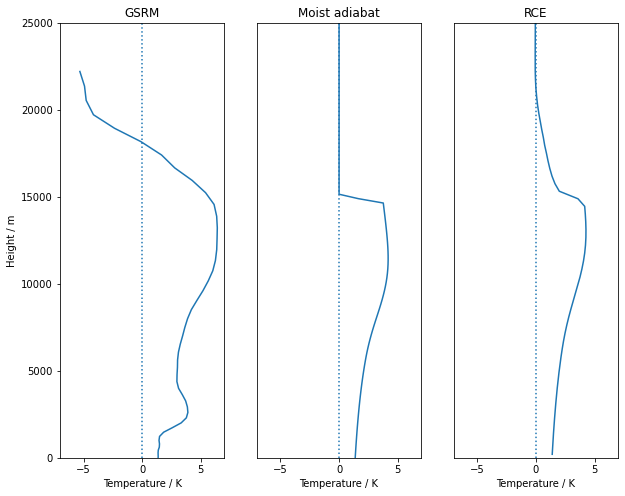

In [35]:
def plot_monsoon_delta(ax, d1, d2, var, **kwargs):
    p1 = d1[var].values
    p2 = d2[var].values
    h = d1['zg'].values
    plot = ax.plot(p2-p1,h, **kwargs)
    return plot

def plot_adiabat_delta(ax, p_surf, T_s1, T_s2, T_min, **kwargs):
    global ymax
    h = np.linspace(0, ymax, num=100)
    p = hydrostratic_profile(h, p_surf)
    t1 = get_moist_adiabat(p,  T_s=T_s1, T_min=T_min)
    t2 = get_moist_adiabat(p,  T_s=T_s2, T_min=T_min)
    # p = hydrostratic_profile(h, p_surf)
    plot = ax.plot(t2-t1,h, **kwargs)
    return plot

fig, axs = plt.subplots(1,3,figsize=(10,8))

ax = axs[0]
ax.axvline(0,ls=':')
plot_monsoon_delta(ax, cold, warm, 'ta')
ax.set_xlabel('Temperature / K')
ax.set_ylabel('Height / m')
ax.set_title('GSRM')

ax = axs[1]
ax.axvline(0,ls=':')
p_surf = cold['pfull'].values[-1]
T_min = np.nanmin(cold['ta'].values)
plot_adiabat_delta(ax, p_surf, cold['ta'].values[-1], warm['ta'].values[-1], T_min, label='Moist adiabat')
ax.set_xlabel('Temperature / K')
pu.remove_ticks(ax, borders=['left', 'right'])
ax.set_title('Moist adiabat')

ax = axs[2]
ax.axvline(0,ls=':')
ax.plot(np.ravel(konrad_ssp585.T.values) - np.ravel(konrad_control.T.values), np.ravel(konrad_ssp585.z.values), label='RCE')
ax.set_title('RCE')
ax.set_xlabel('Temperature / K')
pu.remove_ticks(ax, borders=['left', 'right'])

xlim = [-7,7]
for ax in axs:
    ax.set_xlim(xlim)
    ax.set_ylim([0,ymax])


pu.savefig(fig, './img/deltas_comparison.png')
fig.show()

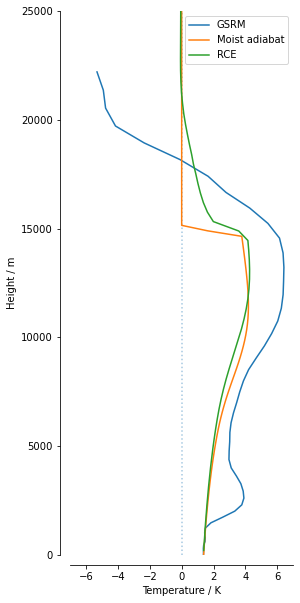

In [36]:
fig, ax = plt.subplots(figsize=(4,10))

xlim = [-7,7]
ax.set_xlabel('Temperature / K')
ax.set_ylabel('Height / m')
ax.set_xlim(xlim)
ax.set_ylim([0,ymax])
pu.adjust_spines(ax,['left', 'bottom'])
ax.axvline(0,ls=':', alpha=0.4)

plot_monsoon_delta(ax, cold, warm, 'ta', label='GSRM')
p_surf = cold['pfull'].values[-1]
T_min = np.nanmin(cold['ta'].values)
plot_adiabat_delta(ax, p_surf, cold['ta'].values[-1], warm['ta'].values[-1], T_min, label='Moist adiabat')
ax.plot(np.ravel(konrad_ssp585.T.values) - np.ravel(konrad_control.T.values), np.ravel(konrad_ssp585.z.values), label='RCE')

ax.legend()

pu.savefig(fig, './img/deltas_comparison_joined.png')
fig.show()

## Tropical temperature profile

Maybe the gap between the moist adiabatic profile and the *Monsoon* simulation is smaller in a domain, that is dominated by deep convection. 


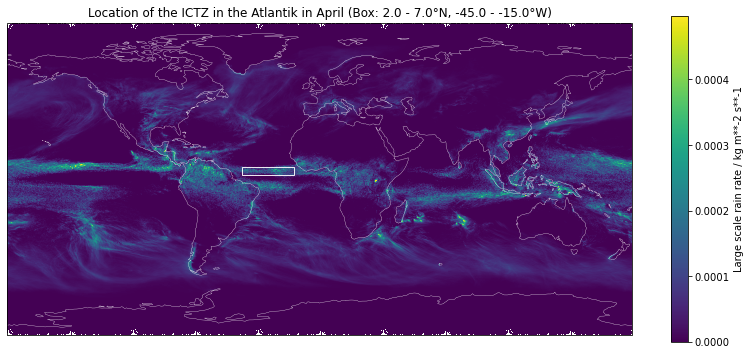

In [37]:
def tropical_convection_box():
    return ((2.0,7.0),(-45.0,-15.0))

# this takes aroung 40s
import intake
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import matplotlib.patches as patches
import datashader
from datashader.mpl_ext import dsshow

import cartopy.crs as ccrs
import cartopy.feature as cf

cat_yaml = "/work/bd1154/highresmonsoon/monsoon2.yaml"
cat = intake.open_catalog(cat_yaml)
data = cat["luk1000"].atm2d.to_dask()
grid = cat.grids[data.uuidOfHGrid].to_dask()
var = 'rain_gsp_rate'
variable = data[var].isel(time=range(1000,1500)).mean(dim='time')

projection = ccrs.PlateCarree()
coords = projection.transform_points(
    ccrs.Geodetic(),
    np.rad2deg(grid.clon),
    np.rad2deg(grid.clat),)

figsize=(14, 6)
fig, ax = plt.subplots(figsize=figsize, subplot_kw={"projection": projection})
fig.canvas.draw_idle()
ax.add_feature(cf.COASTLINE, linewidth=0.3, color='white')
box = tropical_convection_box()
anchor = box[1][0], box[0][0]
extent = box[1][1] - box[1][0], box[0][1] - box[0][0]
ax.add_patch(patches.Rectangle(anchor, *extent, linewidth=0.9, edgecolor='white', facecolor='none'))

ax.set_title(f'Location of the ICTZ in the Atlantik in April (Box: {box[0][0]} - {box[0][1]}°N, {box[1][0]} - {box[1][1]}°W)')
artist = dsshow(
    pd.DataFrame({
        "val": variable.values,
        "x": coords[:, 0],
        "y": coords[:, 1],
    }),
    datashader.Point('x', 'y'),
    datashader.mean('val'),
    ax=ax,
)
fig.colorbar(artist, label=f"{data[var].attrs['name']} / {data[var].units}")
plt.show()

In [38]:
import prelim
import xarray as xr
import plot_utils as pu
import numpy as np
import os

def monsoon_2d_data_available(experiment):
    mcat = prelim.monsooon_catalog()
    return 'atm2d' in list(mcat[experiment])

def get_2d_ensemble(experiment_names): 
    for experiment in experiment_names:
        if not monsoon_2d_data_available(experiment): raise ValueError(f"no 2D data available for {experiment}") 
    ensemble = list()
    for experiment in experiment_names:
        data = prelim.monsoon_dataset(experiment, grid=True, type='atm2d')
        ensemble.append(data.expand_dims(dim='member'))
    return xr.concat(ensemble, dim='member')

def monsoon_3d_data_available(experiment):
    mcat = prelim.monsooon_catalog()
    return 'atm3d' in list(mcat[experiment])

def get_3d_ensemble(experiment_names): 
    for experiment in experiment_names:
        if not monsoon_3d_data_available(experiment): raise ValueError(f"no 3D data available for {experiment}") 
    ensemble = list()
    for experiment in experiment_names:
        data = prelim.monsoon_dataset(experiment, grid=True, type='atm3d')
        ensemble.append(data.expand_dims(dim='member'))
    return xr.concat(ensemble, dim='member')

def get_3d_eureca_april_ensemble(exp_list, discard_spinup=True):
    data = get_3d_ensemble(exp_list)
    data = cut_out_eureca_domain(data)
    data = extract_month(data, 'april')
    if discard_spinup:
        data = discard_first_time_steps(data)
    # data = data.dropna(dim='fulllevel')
    return data

def get_3d_tropical_april_ensemble(exp_list, discard_spinup=True):
    data = get_3d_ensemble(exp_list)
    data = cut_out_tropical_convection_box(data)
    data = extract_month(data, 'april')
    if discard_spinup:
        data = discard_first_time_steps(data)
    # data = data.dropna(dim='fulllevel')
    return data

def drop_nan(x):
    # https://stackoverflow.com/a/47486199
    return x[~np.isnan(x)]

def drop_extra_timesteps(a,b):
    if   len(a.time.values) > len(b.time.values):
        long = a; short = b; order='ab'
    elif len(a.time.values) < len(b.time.values):
        long = b; short = a; order='ba'
    else: # equal length
        return a,b
    
    extras = long.time.values[np.isin(long.time, short.time, invert=True)]
    for extra in extras:
        long = long.where(long.time != extra, drop=True)
    if order == 'ab':
        return long, short
    else:
        return short, long

def extract_month(data, month):
    if type(month) == type('string'):
        month = pu.month2int(month)
    # https://stackoverflow.com/a/60793478
    month_idxs=data.groupby('time.month').groups[month]
    return data.isel(time=month_idxs)

def discard_first_time_steps(data, x=1):
    return data.isel(time=[i + x for i in range(int(np.ravel(data.time.shape))-x)])

def cut_out_tropical_convection_box(dataset):
    domain_limits = tropical_convection_box()
    return prelim.cut_latlon_box(dataset, domain_limits)

scenarios = {'control' : {'filename' : 'luk100X_control_tropic.nc', 'ensemble_list' : ['luk1001', 'luk1002', 'luk1003']},
             'ssp585'  : {'filename' : 'luk102X_ssp585_tropic.nc',  'ensemble_list' : ['luk1021', 'luk1022', 'luk1023']}}

for key in scenarios:
    if os.path.exists(scenarios[key]['filename']):
        scenarios[key]['data'] = xr.open_dataset(scenarios[key]['filename'])
    else:
        data = get_3d_tropical_april_ensemble()
        data = data.copy().mean(dim=['time','member','cell'])
        scenarios[key]['data'] = data
        data.to_netcdf(scenarios[key]['filename'])

warm_trop = scenarios['ssp585']['data']
cold_trop = scenarios['control']['data']

ModuleNotFoundError: No module named 'prelim'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

orderly_print_values(warm['pfull'].values[-1], cold['pfull'].values[-1], 'surface pressure [Pa]:')
orderly_print_values(warm['ta'].values[-1], cold['ta'].values[-1], 'surface temperature [K]:', precision=(1,2))
orderly_print_values(np.nanmin(warm['ta'].values), np.nanmin(cold['ta'].values), 'cold-point temperature [K]: ', precision=(1,2))
orderly_print_values(warm['zg'].values[np.nanargmin(warm['ta'].values)], cold['zg'].values[np.nanargmin(cold['ta'].values)], 'cold-point height [m]: ')

figsize=(10,8)
fig, axs = plt.subplots(1,2, figsize=figsize)
geometry_comparison_plot(axs[0],[cold,warm],          'ta', labels=['Monsoon Control', 'Monsoon SSP585'])
geometry_comparison_plot(axs[1],[cold_trop,warm_trop],'ta', labels=['Monsoon Control', 'Monsoon SSP585'])

for ax in axs: ax.set_ylim(0,23000)
pu.remove_ticks(axs[1], ['left','right'])
axs[1].set_ylabel(None)
axs[0].set_title('Trade wind region')
axs[1].set_title('Tropical convection')
plt.show()

In [ ]:
figsize=(10,8)
fig, axs = plt.subplots(1,2, figsize=figsize)
geometry_comparison_plot(axs[0], [cold,cold_trop], 'ta', labels=['Trades','ITCZ'])
geometry_comparison_plot(axs[1], [warm,warm_trop], 'ta', labels=['Trades','ITCZ'])

h = 2500
for ax in axs:
    ax.set_ylim(0,23000)
    ax.axhline(h, ls='--', color='g', label=f"{h}m")
    ax.legend()
pu.remove_ticks(axs[1], ['left','right'])
axs[1].set_ylabel(None)
axs[0].set_title('Control')
axs[1].set_title('Warming')
plt.show()

## Conclusion

The elevation of the tropopause is hard to capture. Using an equilibrated RCE (using `konrad`) only slightly improved the quality of the profile compared to a simple moist adiabat (using `konrad`s set of equations). Especially in the lower atmosphere using a RCE brings no advantage. Implementing a boundary layer greatly improves the fit to the atmospheric profile in the control simulation. This effect is nulled in the warming scenario, because of a change in the lower atmospheric structure. It may even be of advantage that the tropopause does not rise as much as the *Monsoon* simulations suggest. If we raise the tropopause, we might have to stretch other fields to fit the new tropopause (e.g. winds). The main focus of our study is shallow cumulus feedback. These are low clouds and thus the lower atmosphere should be our main focus. 

<!--

### remarks by other people:
* tigers: what about the eureca simulation profile? what about the initial field?
* dtc: accept and describe differences to moist adiabat
* akn: maybe its better, that tropopause does not rise. so you dont have to stretch the wind field
* jule: one concern was that non rising tropopause will have wrong OLR, which affects CRE. but my focus is shallow cumulus, thus shortwave is much more importanter

### Quantitative description

The lifting of the tropopause is similar to the lifting of the emission height (Thuburn and Craig, 2000). 

$$
\frac{\partial H_T}{\partial T_S} = \frac{1}{\Gamma} - \frac{H_T}{\Gamma} \frac{\partial \Gamma}{\partial T_S}
$$

(Vallis et al., 2015)

**Reference:** 
* Lin, P., Paynter, D., Ming, Y., & Ramaswamy, V. (2017). Changes of the tropical tropopause layer under global warming. *Journal of Climate*, 30(4), 1245-1258.
* Thuburn, J., & Craig, G. C. (2000). Stratospheric influence on tropopause height: The radiative constraint. *Journal of the atmospheric sciences*, 57(1), 17-28.
* Vallis, G. K., Zurita‐Gotor, P., Cairns, C., & Kidston, J. (2015). Response of the large‐scale structure of the atmosphere to global warming. *Quarterly Journal of the Royal Meteorological Society*, 141(690), 1479-1501.
-->